(35887, 3)
[0 2 4 6 3 5 1]
(35887, 48, 48, 1)
(28709, 48, 48, 1) (3589, 48, 48, 1) (3589, 48, 48, 1) (28709,)
DONE


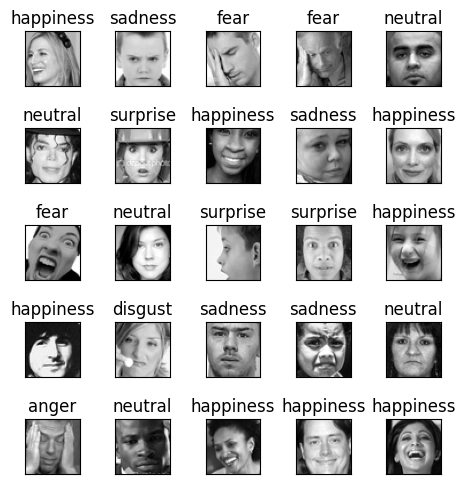

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
# import torchvision
# from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import cv2

df = pd.read_csv('./data/fer2013/fer2013/fer2013.csv')

print(df.shape)
print(df.emotion.unique()) 

emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

X = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
X = np.stack(X, axis=0)
print(X.shape)

y = np.array(df.emotion)

# First separate data into training set and remaining set (to be used for testing and valid)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, shuffle=True, train_size=0.8)

X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, shuffle=True, test_size=0.5)


print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape)

fig = plt.figure(1, (5, 5))
img_size = 48
for i in range(25):
    img = X_train[i]
    ax = plt.subplot(5,5, i+1)
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(emotion_label_to_text[y_train[i]])
    plt.tight_layout()
    
    
class ImgDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)

X_valid -= np.mean(X_valid, axis=0)
X_valid /= np.std(X_valid, axis=0)

X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)

train_data = ImgDataset(X_train, y_train)
valid_data = ImgDataset(X_valid, y_valid)
test_data = ImgDataset(X_test, y_test)

    
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)



def train_model(model, dataloaders, criterion, optimizer, num_epochs=30, weights_name='weight_save', is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    loss_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.permute(0,3,1,2)
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + "_state_dict.pth")
                torch.save(model, weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history, train_acc_history

print("DONE")

In [15]:
class ConvNet(nn.Module):
    def __init__(self, num_classes: int = 7) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            
            # 1st convo layer
            nn.Conv2d(1, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Dropout(0.2),
            
            # 2nd convo layer
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Dropout(0.2),
            
            # 3rd convo layer
            nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            
        )
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        
        #fully connected neural networks
        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
#         x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [16]:
dataloaders = { 'train': train_dataloader, 'val': valid_dataloader }
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)

num_classes = 7
print("Num classes", num_classes)
criterion = nn.CrossEntropyLoss()
model = ConvNet(num_classes=num_classes).to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
best_model, val_acc_history, loss_acc_history, train_acc_history = train_model(model, dataloaders, 
                                                                                   criterion, optimizer, 30, 
                                                                                   'convnet_ADAM_BatchNorm_With_normalization')

Using device cuda:0
Num classes 7
Epoch 0/29
----------
train Loss: 1.7081 Acc: 0.3137
Epoch time taken:  49.61681628227234
val Loss: 1.5749 Acc: 0.3909
Epoch time taken:  50.132817029953

Epoch 1/29
----------
train Loss: 1.5176 Acc: 0.4128
Epoch time taken:  56.41290879249573
val Loss: 1.4242 Acc: 0.4567
Epoch time taken:  56.911908864974976

Epoch 2/29
----------
train Loss: 1.4101 Acc: 0.4558
Epoch time taken:  67.06935262680054
val Loss: 1.3428 Acc: 0.4823
Epoch time taken:  67.57935643196106

Epoch 3/29
----------
train Loss: 1.3291 Acc: 0.4887
Epoch time taken:  71.26136660575867
val Loss: 1.2750 Acc: 0.5127
Epoch time taken:  71.75441551208496

Epoch 4/29
----------
train Loss: 1.2599 Acc: 0.5185
Epoch time taken:  73.70251035690308
val Loss: 1.2055 Acc: 0.5361
Epoch time taken:  74.2045111656189

Epoch 5/29
----------
train Loss: 1.2034 Acc: 0.5409
Epoch time taken:  70.40608620643616
val Loss: 1.1723 Acc: 0.5587
Epoch time taken:  70.90508604049683

Epoch 6/29
----------
trai